<a href="https://colab.research.google.com/github/KINGSTING/Sugarcane_CNN_ComputerVision/blob/main/Sugarcane_CNN_ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub

import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Download latest version
print("Downloading dataset...")
path = kagglehub.dataset_download("nirmalsankalana/sugarcane-leaf-disease-dataset")

print("Path to dataset files:", path)

# Check what is inside the folder to ensure it downloaded correctly
print("\nFolders inside dataset:", os.listdir(path))

100%|██████████| 160M/160M [00:08<00:00, 20.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nirmalsankalana/sugarcane-leaf-disease-dataset/versions/1

Folders inside dataset: ['Mosaic', 'RedRot', 'Yellow', 'Healthy', 'Rust']


In [ ]:
# We define where our data is. Change this path to where you uploaded your folder.
DATASET_PATH = path

# Image parameters (Standard for Thesis projects)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Data Augmentation & Normalization
# This makes your model smarter by rotating/zooming images slightly,
# so it recognizes the disease even if the camera angle is weird.
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values (0-1)
    rotation_range=20,     # Rotate images randomly
    width_shift_range=0.2, # Move image left/right
    height_shift_range=0.2,# Move image up/down
    shear_range=0.2,       # Distort image
    zoom_range=0.2,        # Zoom in
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',
    validation_split=0.2   # Use 20% of data for testing accuracy
)

# Load Training Data (80%)
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load Validation Data (20%)
validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(f"Classes found: {train_generator.class_indices}")

Found 2019 images belonging to 5 classes.
Found 502 images belonging to 5 classes.
Classes found: {'Healthy': 0, 'Mosaic': 1, 'RedRot': 2, 'Rust': 3, 'Yellow': 4}


In [ ]:
from tensorflow.keras import layers, models

# This architecture is designed to capture TEXTURES (stripes/spots)
model = models.Sequential([
    # Layer 1: The "Rough Shape" Detector
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),

    # Layer 2: The "Pattern" Detector (Finds stripes vs spots)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Layer 3: The "Detail" Detector (Finds specific texture nuances)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Layer 4: Deep Feature Extraction
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten results into a 1D vector
    layers.Flatten(),

    # Dense Layer (The decision maker)
    layers.Dropout(0.5), # Drops 50% of neurons randomly to prevent overfitting
    layers.Dense(512, activation='relu'),

    # Output Layer (One neuron per disease class)
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Print the summary to confirm it works
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,173 (13.18 MB)

 Trainable params: 3,455,173 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
# NOTE: Increase 'epochs' to 25-50 for your final thesis run
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=15
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.2489 - loss: 1.5843 - val_accuracy: 0.2771 - val_loss: 1.6153
Epoch 2/15
 1/63 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.3125 - loss: 1.5526

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 230ms/step - accuracy: 0.3125 - loss: 1.5526 - val_accuracy: 0.2958 - val_loss: 1.5163
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.3730 - loss: 1.3649 - val_accuracy: 0.3229 - val_loss: 1.4473
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.4375 - loss: 1.1947 - val_accuracy: 0.3583 - val_loss: 1.4299
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.4480 - loss: 1.2443 - val_accuracy: 0.4750 - val_loss: 1.1537
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.5938 - loss: 0.9699 - val_accuracy: 0.4854 - val_loss: 1.2137
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5739 - loss: 1.0292 - val_accuracy: 0.5604 - val_loss: 1.1012
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 308ms/step - accuracy: 0.7188 - loss: 0.8053 - val_accuracy: 0.5229 - val_loss: 1.1844
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.6643 - loss: 0.8167 - val_accuracy: 0.5583 - val_

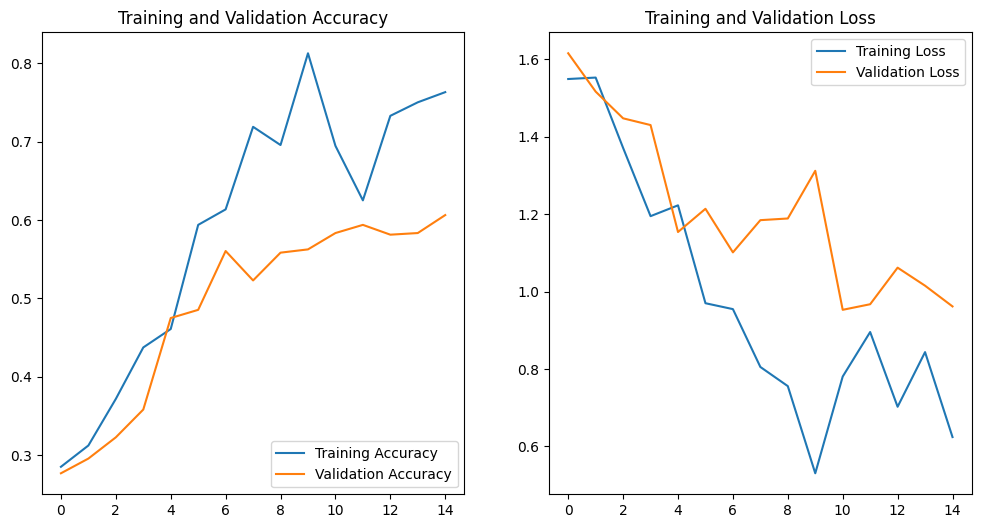

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('sugarcane_disease_model.h5')
print("Model saved successfully!")

Model saved successfully!


✅ Model loaded!

⬇️ CLICK THE BUTTON BELOW TO UPLOAD A LEAF IMAGE ⬇️


Saving test4-sugarcane.jpg to test4-sugarcane.jpg

Analyzing test4-sugarcane.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
--------------------------------------
🧠 DIAGNOSIS: RedRot
📊 CONFIDENCE: 93.67%
--------------------------------------


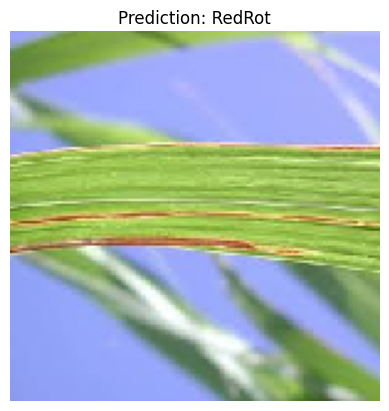

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files
import io

# 1. Load the model (if not already loaded)
try:
    model = load_model('sugarcane_disease_model.h5')
    print("✅ Model loaded!")
except:
    print("❌ Model not found. Please run the training step first.")

# 2. Define Labels
class_labels = {0: 'Healthy', 1: 'Mosaic', 2: 'RedRot', 3: 'Rust', 4: 'Yellow'}

# 3. CREATE UPLOAD BUTTON
print("\n⬇️ CLICK THE BUTTON BELOW TO UPLOAD A LEAF IMAGE ⬇️")
uploaded = files.upload()

# 4. Process whatever file you uploaded
for filename in uploaded.keys():
    print(f"\nAnalyzing {filename}...")

    # Load image from the upload
    path = filename
    img = image.load_img(path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    predictions = model.predict(img_array)
    score = predictions[0]

    predicted_label = class_labels[np.argmax(score)]
    confidence = 100 * np.max(score)

    # Show Results
    print(f"--------------------------------------")
    print(f"🧠 DIAGNOSIS: {predicted_label}")
    print(f"📊 CONFIDENCE: {confidence:.2f}%")
    print(f"--------------------------------------")

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}")
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


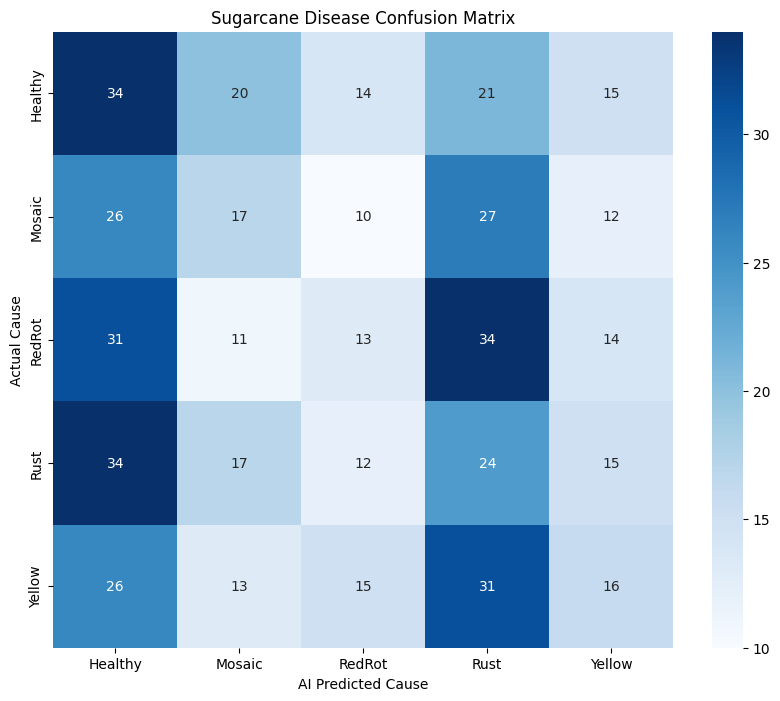

              precision    recall  f1-score   support

     Healthy       0.23      0.33      0.27       104
      Mosaic       0.22      0.18      0.20        92
      RedRot       0.20      0.13      0.16       103
        Rust       0.18      0.24      0.20       102
      Yellow       0.22      0.16      0.18       101

    accuracy                           0.21       502
   macro avg       0.21      0.21      0.20       502
weighted avg       0.21      0.21      0.20       502



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Get True Labels and Predicted Labels from Validation Set
# Reset generator to start of loop
validation_generator.reset()

# Get predictions (this might take a minute)
Y_pred = model.predict(validation_generator, validation_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1) # Convert probabilities to class labels

# Get true labels
y_true = validation_generator.classes

# Ensure lengths match (sometimes generators loop weirdly)
# We truncate to the smallest length to be safe
limit = min(len(y_pred), len(y_true))
y_pred = y_pred[:limit]
y_true = y_true[:limit]

# 2. Create the Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plot it nicely using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))

plt.ylabel('Actual Cause')
plt.xlabel('AI Predicted Cause')
plt.title('Sugarcane Disease Confusion Matrix')
plt.show()

# 4. Print a detailed text report (Precision/Recall)
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))